In [1]:
import os
from importlib.resources import files
import time

import numpy as np
import torch
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt

from fastdtw import fastdtw
# from scipy.spatial.distance import cosine
# from sklearn.metrics.pairwise import cosine_similarity
from learn_embedding.utils.soft_dtw_cuda import SoftDTW

from learn_embedding.approximators import *
from learn_embedding.covariances import *
from learn_embedding.kernels import SquaredExp
from learn_embedding.embedding import Embedding
from learn_embedding.dynamics import FirstGeometry, SecondGeometry
from learn_embedding.utils import *
from learn_embedding.loss import *

In [2]:
dim = 2
num_traj = 7  # Number of trajectories
num_samples = 1000  # Desired number of samples per trajectory
split = int(np.round(num_traj*0.6))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
data_x = []
data_y = []

for i in range(1, num_traj+1):
    # Load trajectory data
    data = np.loadtxt("../learn_embedding/data/toycase/trajectory_" + str(i) + ".csv")
    
    # subsample
    idx = DataProcess.subsample(data[:,:2], num_samples)
    data[idx,:2] -= data[-1,:2]
    data[-1,2:4] = np.zeros(2)
    data[-1,-2:] = np.zeros(2)
    
    # add to datset
    data_x.append(data[idx,:4])
    data_y.append(data[idx,-2:])

In [4]:
reps = 1
num_neurons = [64]
num_layers = 2

cosine_similarity = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
sdtw = SoftDTW(use_cuda=use_cuda, gamma=0.01)

rmse_log = torch.zeros(reps).to(device)
cos_log = torch.zeros(reps).to(device)
dtw_log = torch.zeros(reps).to(device)

for k in range(reps):
    idx = np.random.permutation(num_traj)
    
    train_x = np.empty((0, 4))
    train_y = np.empty((0, 2))
    
    for i in idx[:split]:
        train_x = np.append(train_x, data_x[i], axis=0)
        train_y = np.append(train_y, data_y[i], axis=0)
        
    train_x = torch.from_numpy(train_x).float().to(device).requires_grad_(True)
    train_y = torch.from_numpy(train_y).float().to(device)

    model = SecondGeometry(Embedding(FeedForward(dim, num_neurons*num_layers, 1)), torch.tensor([0,0]).to(device), SPD(dim), SPD(dim)).to(device)

    trainer = Trainer(model, train_x, train_y)

    trainer.optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
    # trainer.optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-2, weight_decay=1e-1)

    trainer.loss = torch.nn.MSELoss()
    # trainer.loss = torch.nn.SmoothL1Loss()

    trainer.options(normalize=False, shuffle=True, print_loss=True,epochs=2000)
    trainer.train()
    
    for i in idx[split:]:
        test_x = torch.from_numpy(data_x[i]).float().to(device).requires_grad_(True)
        test_y = torch.from_numpy(data_y[i]).float().to(device)
        
        x0 = test_x[0,:].unsqueeze(0)
        streamline = Integrator.second_order(dynamics=model,x0=x0,T=20.0, dt=0.01)[:,0,:]
        
        output = model(test_x).detach()
        
        rmse_log[k] += (output-test_y).square().sum().mean().sqrt()/(num_traj-split)
        cos_log[k] += (1 - cosine_similarity(output, test_y)).mean()/(num_traj-split)
#         dtw_log[k] += (sdtw(output.unsqueeze(0), test_y.unsqueeze(0)) - 0.5*(sdtw(output.unsqueeze(0), output.unsqueeze(0)) + sdtw(test_y.unsqueeze(0), test_y.unsqueeze(0)))).squeeze()/test_y.shape[0]/(num_traj-split)
        dtw_log[k] += (sdtw(streamline[:,:2].unsqueeze(0), test_x[:,:2].unsqueeze(0)) - 0.5*(sdtw(streamline[:,:2].unsqueeze(0), streamline[:,:2].unsqueeze(0)) + sdtw(test_x[:,:2].unsqueeze(0), test_x[:,:2].unsqueeze(0)))).detach().squeeze()/test_x.shape[0]/(num_traj-split)
    
    print("Iter: ", k, "RMSE: ", rmse_log[k].item(), "Cosine: ", cos_log[k].item(), "DTW: ", dtw_log[k].item())    

EPOCH:  0 ITER:  0 LR:  0.01 LOSS:  0.09286890923976898
EPOCH:  1 ITER:  0 LR:  0.01 LOSS:  0.04321873560547829
EPOCH:  2 ITER:  0 LR:  0.01 LOSS:  0.018991347402334213
EPOCH:  3 ITER:  0 LR:  0.01 LOSS:  0.010923279449343681
EPOCH:  4 ITER:  0 LR:  0.01 LOSS:  0.0101170614361763
EPOCH:  5 ITER:  0 LR:  0.01 LOSS:  0.01076529547572136
EPOCH:  6 ITER:  0 LR:  0.01 LOSS:  0.010746673680841923
EPOCH:  7 ITER:  0 LR:  0.01 LOSS:  0.01022939570248127
EPOCH:  8 ITER:  0 LR:  0.01 LOSS:  0.009679068811237812
EPOCH:  9 ITER:  0 LR:  0.01 LOSS:  0.009332872927188873
EPOCH:  10 ITER:  0 LR:  0.01 LOSS:  0.009220961481332779
EPOCH:  11 ITER:  0 LR:  0.01 LOSS:  0.009268946945667267
EPOCH:  12 ITER:  0 LR:  0.01 LOSS:  0.009377636015415192
EPOCH:  13 ITER:  0 LR:  0.01 LOSS:  0.009468168951570988
EPOCH:  14 ITER:  0 LR:  0.01 LOSS:  0.009498344734311104
EPOCH:  15 ITER:  0 LR:  0.01 LOSS:  0.00946030393242836
EPOCH:  16 ITER:  0 LR:  0.01 LOSS:  0.009369632229208946
EPOCH:  17 ITER:  0 LR:  0.01 L

EPOCH:  144 ITER:  0 LR:  0.01 LOSS:  0.00679384171962738
EPOCH:  145 ITER:  0 LR:  0.01 LOSS:  0.006782968062907457
EPOCH:  146 ITER:  0 LR:  0.01 LOSS:  0.0067720371298491955
EPOCH:  147 ITER:  0 LR:  0.01 LOSS:  0.006761045660823584
EPOCH:  148 ITER:  0 LR:  0.01 LOSS:  0.006749990861862898
EPOCH:  149 ITER:  0 LR:  0.01 LOSS:  0.006738873664289713
EPOCH:  150 ITER:  0 LR:  0.01 LOSS:  0.006727694533765316
EPOCH:  151 ITER:  0 LR:  0.01 LOSS:  0.006716452538967133
EPOCH:  152 ITER:  0 LR:  0.01 LOSS:  0.006705148611217737
EPOCH:  153 ITER:  0 LR:  0.01 LOSS:  0.006693783216178417
EPOCH:  154 ITER:  0 LR:  0.01 LOSS:  0.006682353559881449
EPOCH:  155 ITER:  0 LR:  0.01 LOSS:  0.0066708591766655445
EPOCH:  156 ITER:  0 LR:  0.01 LOSS:  0.006659300997853279
EPOCH:  157 ITER:  0 LR:  0.01 LOSS:  0.006647674832493067
EPOCH:  158 ITER:  0 LR:  0.01 LOSS:  0.006635983940213919
EPOCH:  159 ITER:  0 LR:  0.01 LOSS:  0.006624224595725536
EPOCH:  160 ITER:  0 LR:  0.01 LOSS:  0.006612397730350

EPOCH:  285 ITER:  0 LR:  0.01 LOSS:  0.004852266516536474
EPOCH:  286 ITER:  0 LR:  0.01 LOSS:  0.004796960391104221
EPOCH:  287 ITER:  0 LR:  0.01 LOSS:  0.004814568441361189
EPOCH:  288 ITER:  0 LR:  0.01 LOSS:  0.004757544957101345
EPOCH:  289 ITER:  0 LR:  0.01 LOSS:  0.0047598774544894695
EPOCH:  290 ITER:  0 LR:  0.01 LOSS:  0.004726762417703867
EPOCH:  291 ITER:  0 LR:  0.01 LOSS:  0.004715464543551207
EPOCH:  292 ITER:  0 LR:  0.01 LOSS:  0.004687187727540731
EPOCH:  293 ITER:  0 LR:  0.01 LOSS:  0.004670082125812769
EPOCH:  294 ITER:  0 LR:  0.01 LOSS:  0.004655451979488134
EPOCH:  295 ITER:  0 LR:  0.01 LOSS:  0.004628087859600782
EPOCH:  296 ITER:  0 LR:  0.01 LOSS:  0.004621709231287241
EPOCH:  297 ITER:  0 LR:  0.01 LOSS:  0.004582923371344805
EPOCH:  298 ITER:  0 LR:  0.01 LOSS:  0.004577027168124914
EPOCH:  299 ITER:  0 LR:  0.01 LOSS:  0.004557865206152201
EPOCH:  300 ITER:  0 LR:  0.01 LOSS:  0.004520350601524115
EPOCH:  301 ITER:  0 LR:  0.01 LOSS:  0.004526765085756

EPOCH:  426 ITER:  0 LR:  0.01 LOSS:  0.002805497497320175
EPOCH:  427 ITER:  0 LR:  0.01 LOSS:  0.0030899455305188894
EPOCH:  428 ITER:  0 LR:  0.01 LOSS:  0.0046526845544576645
EPOCH:  429 ITER:  0 LR:  0.01 LOSS:  0.0028078528121113777
EPOCH:  430 ITER:  0 LR:  0.01 LOSS:  0.005363470409065485
EPOCH:  431 ITER:  0 LR:  0.01 LOSS:  0.008061460219323635
EPOCH:  432 ITER:  0 LR:  0.01 LOSS:  0.006840945221483707
EPOCH:  433 ITER:  0 LR:  0.01 LOSS:  0.006190921179950237
EPOCH:  434 ITER:  0 LR:  0.01 LOSS:  0.006632007192820311
EPOCH:  435 ITER:  0 LR:  0.01 LOSS:  0.002537437016144395
EPOCH:  436 ITER:  0 LR:  0.01 LOSS:  0.005460621789097786
EPOCH:  437 ITER:  0 LR:  0.01 LOSS:  0.005167858675122261
EPOCH:  438 ITER:  0 LR:  0.01 LOSS:  0.002473233500495553
EPOCH:  439 ITER:  0 LR:  0.01 LOSS:  0.004192976746708155
EPOCH:  440 ITER:  0 LR:  0.01 LOSS:  0.004144386388361454
EPOCH:  441 ITER:  0 LR:  0.01 LOSS:  0.003434619167819619
EPOCH:  442 ITER:  0 LR:  0.01 LOSS:  0.0030804476700

EPOCH:  565 ITER:  0 LR:  0.01 LOSS:  0.0011301060440018773
EPOCH:  566 ITER:  0 LR:  0.01 LOSS:  0.001121019828133285
EPOCH:  567 ITER:  0 LR:  0.01 LOSS:  0.0011331242276355624
EPOCH:  568 ITER:  0 LR:  0.01 LOSS:  0.0011340378550812602
EPOCH:  569 ITER:  0 LR:  0.01 LOSS:  0.0011223121546208858
EPOCH:  570 ITER:  0 LR:  0.01 LOSS:  0.0011130503844469786
EPOCH:  571 ITER:  0 LR:  0.01 LOSS:  0.001116106752306223
EPOCH:  572 ITER:  0 LR:  0.01 LOSS:  0.0011233602417632937
EPOCH:  573 ITER:  0 LR:  0.01 LOSS:  0.0011159334098920226
EPOCH:  574 ITER:  0 LR:  0.01 LOSS:  0.0011067958548665047
EPOCH:  575 ITER:  0 LR:  0.01 LOSS:  0.001104091526940465
EPOCH:  576 ITER:  0 LR:  0.01 LOSS:  0.0011073773493990302
EPOCH:  577 ITER:  0 LR:  0.01 LOSS:  0.001109402277506888
EPOCH:  578 ITER:  0 LR:  0.01 LOSS:  0.0011029482120648026
EPOCH:  579 ITER:  0 LR:  0.01 LOSS:  0.001097102533094585
EPOCH:  580 ITER:  0 LR:  0.01 LOSS:  0.0010949127608910203
EPOCH:  581 ITER:  0 LR:  0.01 LOSS:  0.00109

EPOCH:  703 ITER:  0 LR:  0.01 LOSS:  0.0009754060884006321
EPOCH:  704 ITER:  0 LR:  0.01 LOSS:  0.0009768669260665774
EPOCH:  705 ITER:  0 LR:  0.01 LOSS:  0.0009643712546676397
EPOCH:  706 ITER:  0 LR:  0.01 LOSS:  0.0009587459499016404
EPOCH:  707 ITER:  0 LR:  0.01 LOSS:  0.0009477479034103453
EPOCH:  708 ITER:  0 LR:  0.01 LOSS:  0.0009415448876097798
EPOCH:  709 ITER:  0 LR:  0.01 LOSS:  0.0009348882013000548
EPOCH:  710 ITER:  0 LR:  0.01 LOSS:  0.0009307467262260616
EPOCH:  711 ITER:  0 LR:  0.01 LOSS:  0.0009272606112062931
EPOCH:  712 ITER:  0 LR:  0.01 LOSS:  0.0009248430724255741
EPOCH:  713 ITER:  0 LR:  0.01 LOSS:  0.0009228543494828045
EPOCH:  714 ITER:  0 LR:  0.01 LOSS:  0.0009212610311806202
EPOCH:  715 ITER:  0 LR:  0.01 LOSS:  0.0009198638726957142
EPOCH:  716 ITER:  0 LR:  0.01 LOSS:  0.0009186373208649457
EPOCH:  717 ITER:  0 LR:  0.01 LOSS:  0.0009175374289043248
EPOCH:  718 ITER:  0 LR:  0.01 LOSS:  0.0009166360832750797
EPOCH:  719 ITER:  0 LR:  0.01 LOSS:  0.

EPOCH:  843 ITER:  0 LR:  0.01 LOSS:  0.0008351310389116406
EPOCH:  844 ITER:  0 LR:  0.01 LOSS:  0.0008504599682055414
EPOCH:  845 ITER:  0 LR:  0.01 LOSS:  0.0008701407932676375
EPOCH:  846 ITER:  0 LR:  0.01 LOSS:  0.0008647112990729511
EPOCH:  847 ITER:  0 LR:  0.01 LOSS:  0.0008631208329461515
EPOCH:  848 ITER:  0 LR:  0.01 LOSS:  0.0008421820239163935
EPOCH:  849 ITER:  0 LR:  0.01 LOSS:  0.000828196236398071
EPOCH:  850 ITER:  0 LR:  0.01 LOSS:  0.0008154112147167325
EPOCH:  851 ITER:  0 LR:  0.01 LOSS:  0.0008092770585790277
EPOCH:  852 ITER:  0 LR:  0.01 LOSS:  0.000808342476375401
EPOCH:  853 ITER:  0 LR:  0.01 LOSS:  0.0008113173535093665
EPOCH:  854 ITER:  0 LR:  0.01 LOSS:  0.0008173783426173031
EPOCH:  855 ITER:  0 LR:  0.01 LOSS:  0.0008239480666816235
EPOCH:  856 ITER:  0 LR:  0.01 LOSS:  0.0008349413983523846
EPOCH:  857 ITER:  0 LR:  0.01 LOSS:  0.0008419653167948127
EPOCH:  858 ITER:  0 LR:  0.01 LOSS:  0.0008599773864261806
EPOCH:  859 ITER:  0 LR:  0.01 LOSS:  0.00

EPOCH:  981 ITER:  0 LR:  0.01 LOSS:  0.0008065723231993616
EPOCH:  982 ITER:  0 LR:  0.01 LOSS:  0.0008653437835164368
EPOCH:  983 ITER:  0 LR:  0.01 LOSS:  0.0008507773163728416
EPOCH:  984 ITER:  0 LR:  0.01 LOSS:  0.0008389934664592147
EPOCH:  985 ITER:  0 LR:  0.01 LOSS:  0.0007804788765497506
EPOCH:  986 ITER:  0 LR:  0.01 LOSS:  0.0007499491912312806
EPOCH:  987 ITER:  0 LR:  0.01 LOSS:  0.0007505911053158343
EPOCH:  988 ITER:  0 LR:  0.01 LOSS:  0.000774054613430053
EPOCH:  989 ITER:  0 LR:  0.01 LOSS:  0.0008093448122963309
EPOCH:  990 ITER:  0 LR:  0.01 LOSS:  0.000812297803349793
EPOCH:  991 ITER:  0 LR:  0.01 LOSS:  0.0008161001605913043
EPOCH:  992 ITER:  0 LR:  0.01 LOSS:  0.0007834301795810461
EPOCH:  993 ITER:  0 LR:  0.01 LOSS:  0.0007597834337502718
EPOCH:  994 ITER:  0 LR:  0.01 LOSS:  0.0007439823821187019
EPOCH:  995 ITER:  0 LR:  0.01 LOSS:  0.0007446649251505733
EPOCH:  996 ITER:  0 LR:  0.01 LOSS:  0.0007578161894343793
EPOCH:  997 ITER:  0 LR:  0.01 LOSS:  0.00

EPOCH:  1121 ITER:  0 LR:  0.01 LOSS:  0.0007740450673736632
EPOCH:  1122 ITER:  0 LR:  0.01 LOSS:  0.0007562267128378153
EPOCH:  1123 ITER:  0 LR:  0.01 LOSS:  0.0007214705110527575
EPOCH:  1124 ITER:  0 LR:  0.01 LOSS:  0.0007042373763397336
EPOCH:  1125 ITER:  0 LR:  0.01 LOSS:  0.0007022421923466027
EPOCH:  1126 ITER:  0 LR:  0.01 LOSS:  0.0007117271306924522
EPOCH:  1127 ITER:  0 LR:  0.01 LOSS:  0.0007292936788871884
EPOCH:  1128 ITER:  0 LR:  0.01 LOSS:  0.0007417782326228917
EPOCH:  1129 ITER:  0 LR:  0.01 LOSS:  0.0007601877441629767
EPOCH:  1130 ITER:  0 LR:  0.01 LOSS:  0.0007523016538470984
EPOCH:  1131 ITER:  0 LR:  0.01 LOSS:  0.0007504411623813212
EPOCH:  1132 ITER:  0 LR:  0.01 LOSS:  0.0007305854232981801
EPOCH:  1133 ITER:  0 LR:  0.01 LOSS:  0.0007185701979324222
EPOCH:  1134 ITER:  0 LR:  0.01 LOSS:  0.0007066905382089317
EPOCH:  1135 ITER:  0 LR:  0.01 LOSS:  0.0007004534127190709
EPOCH:  1136 ITER:  0 LR:  0.01 LOSS:  0.0006978905876167119
EPOCH:  1137 ITER:  0 LR

EPOCH:  1260 ITER:  0 LR:  0.01 LOSS:  0.0007534250034950674
EPOCH:  1261 ITER:  0 LR:  0.01 LOSS:  0.0007557952776551247
EPOCH:  1262 ITER:  0 LR:  0.01 LOSS:  0.0007269742200151086
EPOCH:  1263 ITER:  0 LR:  0.01 LOSS:  0.0007164849084801972
EPOCH:  1264 ITER:  0 LR:  0.01 LOSS:  0.0006962962215766311
EPOCH:  1265 ITER:  0 LR:  0.01 LOSS:  0.0006858066190034151
EPOCH:  1266 ITER:  0 LR:  0.01 LOSS:  0.000676727679092437
EPOCH:  1267 ITER:  0 LR:  0.01 LOSS:  0.0006720449309796095
EPOCH:  1268 ITER:  0 LR:  0.01 LOSS:  0.000670076347887516
EPOCH:  1269 ITER:  0 LR:  0.01 LOSS:  0.0006702885730192065
EPOCH:  1270 ITER:  0 LR:  0.01 LOSS:  0.0006721396930515766
EPOCH:  1271 ITER:  0 LR:  0.01 LOSS:  0.0006750253378413618
EPOCH:  1272 ITER:  0 LR:  0.01 LOSS:  0.0006796377128921449
EPOCH:  1273 ITER:  0 LR:  0.01 LOSS:  0.0006841469439677894
EPOCH:  1274 ITER:  0 LR:  0.01 LOSS:  0.0006929267547093332
EPOCH:  1275 ITER:  0 LR:  0.01 LOSS:  0.0006995451403781772
EPOCH:  1276 ITER:  0 LR: 

EPOCH:  1397 ITER:  0 LR:  0.01 LOSS:  0.0007594253984279931
EPOCH:  1398 ITER:  0 LR:  0.01 LOSS:  0.0008099855040200055
EPOCH:  1399 ITER:  0 LR:  0.01 LOSS:  0.0007846167427487671
EPOCH:  1400 ITER:  0 LR:  0.01 LOSS:  0.0008085794979706407
EPOCH:  1401 ITER:  0 LR:  0.01 LOSS:  0.0007524428074248135
EPOCH:  1402 ITER:  0 LR:  0.01 LOSS:  0.0007334474939852953
EPOCH:  1403 ITER:  0 LR:  0.01 LOSS:  0.000689373177010566
EPOCH:  1404 ITER:  0 LR:  0.01 LOSS:  0.000667544431053102
EPOCH:  1405 ITER:  0 LR:  0.01 LOSS:  0.000653537455946207
EPOCH:  1406 ITER:  0 LR:  0.01 LOSS:  0.0006504501216113567
EPOCH:  1407 ITER:  0 LR:  0.01 LOSS:  0.0006552551058121026
EPOCH:  1408 ITER:  0 LR:  0.01 LOSS:  0.0006645603571087122
EPOCH:  1409 ITER:  0 LR:  0.01 LOSS:  0.0006796428933739662
EPOCH:  1410 ITER:  0 LR:  0.01 LOSS:  0.0006886515766382217
EPOCH:  1411 ITER:  0 LR:  0.01 LOSS:  0.0007059114868752658
EPOCH:  1412 ITER:  0 LR:  0.01 LOSS:  0.0007042106008157134
EPOCH:  1413 ITER:  0 LR:  

EPOCH:  1537 ITER:  0 LR:  0.01 LOSS:  0.000656174321193248
EPOCH:  1538 ITER:  0 LR:  0.01 LOSS:  0.0006508262013085186
EPOCH:  1539 ITER:  0 LR:  0.01 LOSS:  0.0006443103193305433
EPOCH:  1540 ITER:  0 LR:  0.01 LOSS:  0.0006405977765098214
EPOCH:  1541 ITER:  0 LR:  0.01 LOSS:  0.000637255550827831
EPOCH:  1542 ITER:  0 LR:  0.01 LOSS:  0.0006353632779791951
EPOCH:  1543 ITER:  0 LR:  0.01 LOSS:  0.0006338674575090408
EPOCH:  1544 ITER:  0 LR:  0.01 LOSS:  0.0006329980096779764
EPOCH:  1545 ITER:  0 LR:  0.01 LOSS:  0.0006324336281977594
EPOCH:  1546 ITER:  0 LR:  0.01 LOSS:  0.0006320607499219477
EPOCH:  1547 ITER:  0 LR:  0.01 LOSS:  0.000631750444881618
EPOCH:  1548 ITER:  0 LR:  0.01 LOSS:  0.0006315125501714647
EPOCH:  1549 ITER:  0 LR:  0.01 LOSS:  0.0006313255871646106
EPOCH:  1550 ITER:  0 LR:  0.01 LOSS:  0.0006311419419944286
EPOCH:  1551 ITER:  0 LR:  0.01 LOSS:  0.000630950671620667
EPOCH:  1552 ITER:  0 LR:  0.01 LOSS:  0.0006307908333837986
EPOCH:  1553 ITER:  0 LR:  0

EPOCH:  1673 ITER:  0 LR:  0.01 LOSS:  0.0006204675300978124
EPOCH:  1674 ITER:  0 LR:  0.01 LOSS:  0.0006241768132895231
EPOCH:  1675 ITER:  0 LR:  0.01 LOSS:  0.0006537644658237696
EPOCH:  1676 ITER:  0 LR:  0.01 LOSS:  0.0006867750780656934
EPOCH:  1677 ITER:  0 LR:  0.01 LOSS:  0.000733118737116456
EPOCH:  1678 ITER:  0 LR:  0.01 LOSS:  0.0007314481190405786
EPOCH:  1679 ITER:  0 LR:  0.01 LOSS:  0.0007561839884147048
EPOCH:  1680 ITER:  0 LR:  0.01 LOSS:  0.0006905526388436556
EPOCH:  1681 ITER:  0 LR:  0.01 LOSS:  0.0006492516258731484
EPOCH:  1682 ITER:  0 LR:  0.01 LOSS:  0.000621040933765471
EPOCH:  1683 ITER:  0 LR:  0.01 LOSS:  0.0006179983029142022
EPOCH:  1684 ITER:  0 LR:  0.01 LOSS:  0.0006393350195139647
EPOCH:  1685 ITER:  0 LR:  0.01 LOSS:  0.0006685718544758856
EPOCH:  1686 ITER:  0 LR:  0.01 LOSS:  0.0007110845763236284
EPOCH:  1687 ITER:  0 LR:  0.01 LOSS:  0.0007168377633206546
EPOCH:  1688 ITER:  0 LR:  0.01 LOSS:  0.0007453473517671227
EPOCH:  1689 ITER:  0 LR: 

EPOCH:  1809 ITER:  0 LR:  0.01 LOSS:  0.0006014834507368505
EPOCH:  1810 ITER:  0 LR:  0.01 LOSS:  0.0006009098142385483
EPOCH:  1811 ITER:  0 LR:  0.01 LOSS:  0.0006021590088494122
EPOCH:  1812 ITER:  0 LR:  0.01 LOSS:  0.0006044661859050393
EPOCH:  1813 ITER:  0 LR:  0.01 LOSS:  0.0006074244156479836
EPOCH:  1814 ITER:  0 LR:  0.01 LOSS:  0.00061174196889624
EPOCH:  1815 ITER:  0 LR:  0.01 LOSS:  0.0006144383223727345
EPOCH:  1816 ITER:  0 LR:  0.01 LOSS:  0.0006193749723024666
EPOCH:  1817 ITER:  0 LR:  0.01 LOSS:  0.0006212850566953421
EPOCH:  1818 ITER:  0 LR:  0.01 LOSS:  0.0006274788756854832
EPOCH:  1819 ITER:  0 LR:  0.01 LOSS:  0.0006302271503955126
EPOCH:  1820 ITER:  0 LR:  0.01 LOSS:  0.0006381453713402152
EPOCH:  1821 ITER:  0 LR:  0.01 LOSS:  0.0006397378165274858
EPOCH:  1822 ITER:  0 LR:  0.01 LOSS:  0.0006485540070571005
EPOCH:  1823 ITER:  0 LR:  0.01 LOSS:  0.0006462508463300765
EPOCH:  1824 ITER:  0 LR:  0.01 LOSS:  0.00065321457805112
EPOCH:  1825 ITER:  0 LR:  0

EPOCH:  1945 ITER:  0 LR:  0.01 LOSS:  0.0006189579726196826
EPOCH:  1946 ITER:  0 LR:  0.01 LOSS:  0.0006481398013420403
EPOCH:  1947 ITER:  0 LR:  0.01 LOSS:  0.000662630598526448
EPOCH:  1948 ITER:  0 LR:  0.01 LOSS:  0.0006907155620865524
EPOCH:  1949 ITER:  0 LR:  0.01 LOSS:  0.0006557487649843097
EPOCH:  1950 ITER:  0 LR:  0.01 LOSS:  0.0006333509809337556
EPOCH:  1951 ITER:  0 LR:  0.01 LOSS:  0.0006028744974173605
EPOCH:  1952 ITER:  0 LR:  0.01 LOSS:  0.0005901925032958388
EPOCH:  1953 ITER:  0 LR:  0.01 LOSS:  0.0005919745308347046
EPOCH:  1954 ITER:  0 LR:  0.01 LOSS:  0.0006028005736880004
EPOCH:  1955 ITER:  0 LR:  0.01 LOSS:  0.0006229307036846876
EPOCH:  1956 ITER:  0 LR:  0.01 LOSS:  0.000637889897916466
EPOCH:  1957 ITER:  0 LR:  0.01 LOSS:  0.0006587243406102061
EPOCH:  1958 ITER:  0 LR:  0.01 LOSS:  0.0006546176737174392
EPOCH:  1959 ITER:  0 LR:  0.01 LOSS:  0.0006538428133353591
EPOCH:  1960 ITER:  0 LR:  0.01 LOSS:  0.0006288037402555346
EPOCH:  1961 ITER:  0 LR: 

/home/bernardo/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)


/home/bernardo/.local/lib/python3.10/site-packages/numba/cuda/dispatcher.py:539: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)
SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)


/home/bernardo/.local/lib/python3.10/site-packages/numba/cuda/dispatcher.py:539: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)
SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)
Iter:  0 RMSE:  1.3832333087921143 Cosine:  0.1267070472240448 DTW:  0.40010976791381836


In [7]:
resolution = 100
std = train_x.detach().std(axis=0)
min_ax = train_x.detach().min(axis=0)[0] - std/2
max_ax = train_x.detach().max(axis=0)[0] + std/2
x, y = torch.meshgrid(torch.linspace(min_ax[0], max_ax[0], resolution), torch.linspace(min_ax[1], max_ax[1], resolution), indexing='xy')

grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
grid_v = torch.zeros_like(grid_x).to(device).requires_grad_(True)

potential = model.potential(grid_x).reshape(resolution, -1).cpu().detach().numpy()

field = model(torch.cat((grid_x,grid_v),dim=1))
x_field = field[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_field = field[:, 1].reshape(resolution, -1).cpu().detach().numpy()

x0 = np.empty((0, 4))
test_x = np.empty((0, 4))
for i in idx[split:]:
    x0 = np.append(x0, data_x[i][0,:][np.newaxis, :], axis=0)
    test_x = np.append(test_x, data_x[i], axis=0)
x0 = torch.from_numpy(x0).float().to(device).requires_grad_(True)

x0.data[0,2] = 1.0

streamlines = Integrator.second_order(dynamics=model,x0=x0,T=10.0, dt=0.01).cpu().detach().numpy()

(-0.22079509496688843, 1.0580686330795288)

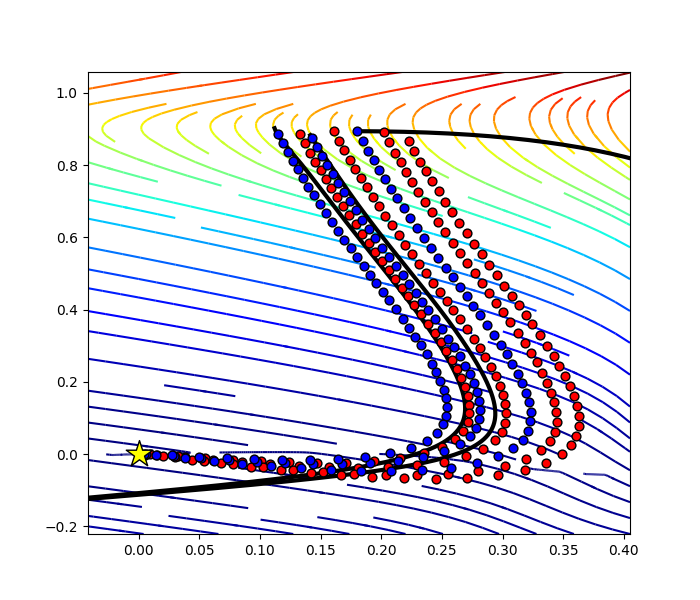

In [8]:
fig, ax = plt.subplots(figsize=(7, 6))

steps = 20
ax.streamplot(x.numpy(), y.numpy(), x_field, y_field, color=potential, cmap="jet", linewidth=1.5, arrowstyle='-', arrowsize=1.5)
ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(test_x[::steps, 0], test_x[::steps, 1], s=40, edgecolors='k', c='blue', zorder=10)

ax.scatter(0.0, 0.0, s=400, edgecolors='k', c='yellow', marker="*", zorder=10)

for i in range(streamlines.shape[1]):
    ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], color='k', linewidth=3.0)
    
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

In [ ]:
data = [rmse_log.cpu(), dtw_log.cpu()*100, cos_log.cpu()*10]
green_diamond = dict(markerfacecolor='g', marker='D')

# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

# Create the figure and axes
fig, ax = plt.subplots(figsize=(6, 6))

# Customize the box plot
boxprops = dict(linewidth=2, color='black', facecolor='lightgray')
medianprops = dict(linewidth=2, color='red')
whiskerprops = dict(linewidth=2, color='black')
capprops = dict(linewidth=2, color='black')
flierprops = green_diamond

boxplot = ax.boxplot(data, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops,
           capprops=capprops, flierprops=flierprops, patch_artist=True)

# Define a list of colors
colors = ['lightblue', 'lightgreen', 'lightyellow']

# Add color to the box plot elements
for patch, color in zip(boxplot['boxes'], colors):
    # Change the fill color of the boxes
    patch.set_facecolor(color)

# Customize the x-axis ticks and labels
plt.xticks([1, 2, 3], ['RMSE', 'DTWD', 'CS'], fontsize=32)
plt.yticks(fontsize=28)
# plt.xlabel('Metrics')

# Add a title and y-axis label if needed
# plt.title('Comparison of Metrics')
# plt.ylabel('Metric Values')

# Adjust the plot layout if needed
plt.tight_layout()

fig.savefig('../outputs/evaluation_learning.png', format='png', dpi=300, bbox_inches="tight")